In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import math
import os
import zipfile
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Load and Preprocess Data

In [ ]:
data_path = "/content/data_complete.csv"
df = pd.read_csv(data_path, parse_dates=["Datetime"], index_col="Datetime")
features = ["Load_Calgary", "Temperature_C", "Wind_Speed_mps", "Is_Weekend", "Is_Holiday", "Day_of_Week_Num"]
df = df[features]
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=features, index=df.index)

In [ ]:
class LoadForecastDataset(Dataset):
    def __init__(self, data, input_len=24, output_len=24):
        self.X, self.y = [], []
        for i in range(len(data) - input_len - output_len):
            x = data[i:i+input_len]
            y = data[i+input_len:i+input_len+output_len, 0]
            self.X.append(x)
            self.y.append(y)
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
data_values = df_scaled.values
input_len = output_len = 24
dataset = LoadForecastDataset(data_values, input_len, output_len)
dataset

In [ ]:
total = len(dataset)
train_size = int(total * 0.7)
val_size = int(total * 0.15)
test_size = total - train_size - val_size

In [ ]:
train_set = torch.utils.data.Subset(dataset, list(range(0, train_size)))
val_set = torch.utils.data.Subset(dataset, list(range(train_size, train_size + val_size)))
test_set = torch.utils.data.Subset(dataset, list(range(train_size + val_size, total)))

In [ ]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

## Initialize LSTM Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 24)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
model = LSTMModel(input_size=len(features)).to(device)

## Train Model

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100
patience = 5  # Number of epochs to wait before stopping
best_val_loss = float('inf')
counter = 0

train_losses, val_losses = [], []

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            val_loss += criterion(output, y_batch).item()

    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    train_losses.append(avg_train)
    val_losses.append(avg_val)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train:.4f}, Val Loss: {avg_val:.4f}")

    # Early Stopping Check
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        counter = 0
        best_model_state = model.state_dict()  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)  # Restore best model
            break

Epoch 1/100, Train Loss: 0.0073, Val Loss: 0.0020
Epoch 2/100, Train Loss: 0.0016, Val Loss: 0.0017
Epoch 3/100, Train Loss: 0.0014, Val Loss: 0.0016
Epoch 4/100, Train Loss: 0.0012, Val Loss: 0.0014
Epoch 5/100, Train Loss: 0.0011, Val Loss: 0.0013
Epoch 6/100, Train Loss: 0.0010, Val Loss: 0.0013
Epoch 7/100, Train Loss: 0.0010, Val Loss: 0.0012
Epoch 8/100, Train Loss: 0.0009, Val Loss: 0.0012
Epoch 9/100, Train Loss: 0.0009, Val Loss: 0.0012
Epoch 10/100, Train Loss: 0.0009, Val Loss: 0.0012
Epoch 11/100, Train Loss: 0.0008, Val Loss: 0.0012
Epoch 12/100, Train Loss: 0.0008, Val Loss: 0.0012
Epoch 13/100, Train Loss: 0.0008, Val Loss: 0.0012
Epoch 14/100, Train Loss: 0.0008, Val Loss: 0.0011
Epoch 15/100, Train Loss: 0.0008, Val Loss: 0.0012
Epoch 16/100, Train Loss: 0.0008, Val Loss: 0.0011
Epoch 17/100, Train Loss: 0.0007, Val Loss: 0.0011
Epoch 18/100, Train Loss: 0.0007, Val Loss: 0.0011
Epoch 19/100, Train Loss: 0.0007, Val Loss: 0.0011
Epoch 20/100, Train Loss: 0.0007, Val Lo

In [ ]:
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/lstm_model.pth")
print("✅ Trained model saved to models/lstm_model.pth")

✅ Trained model saved to models/lstm_model.pth


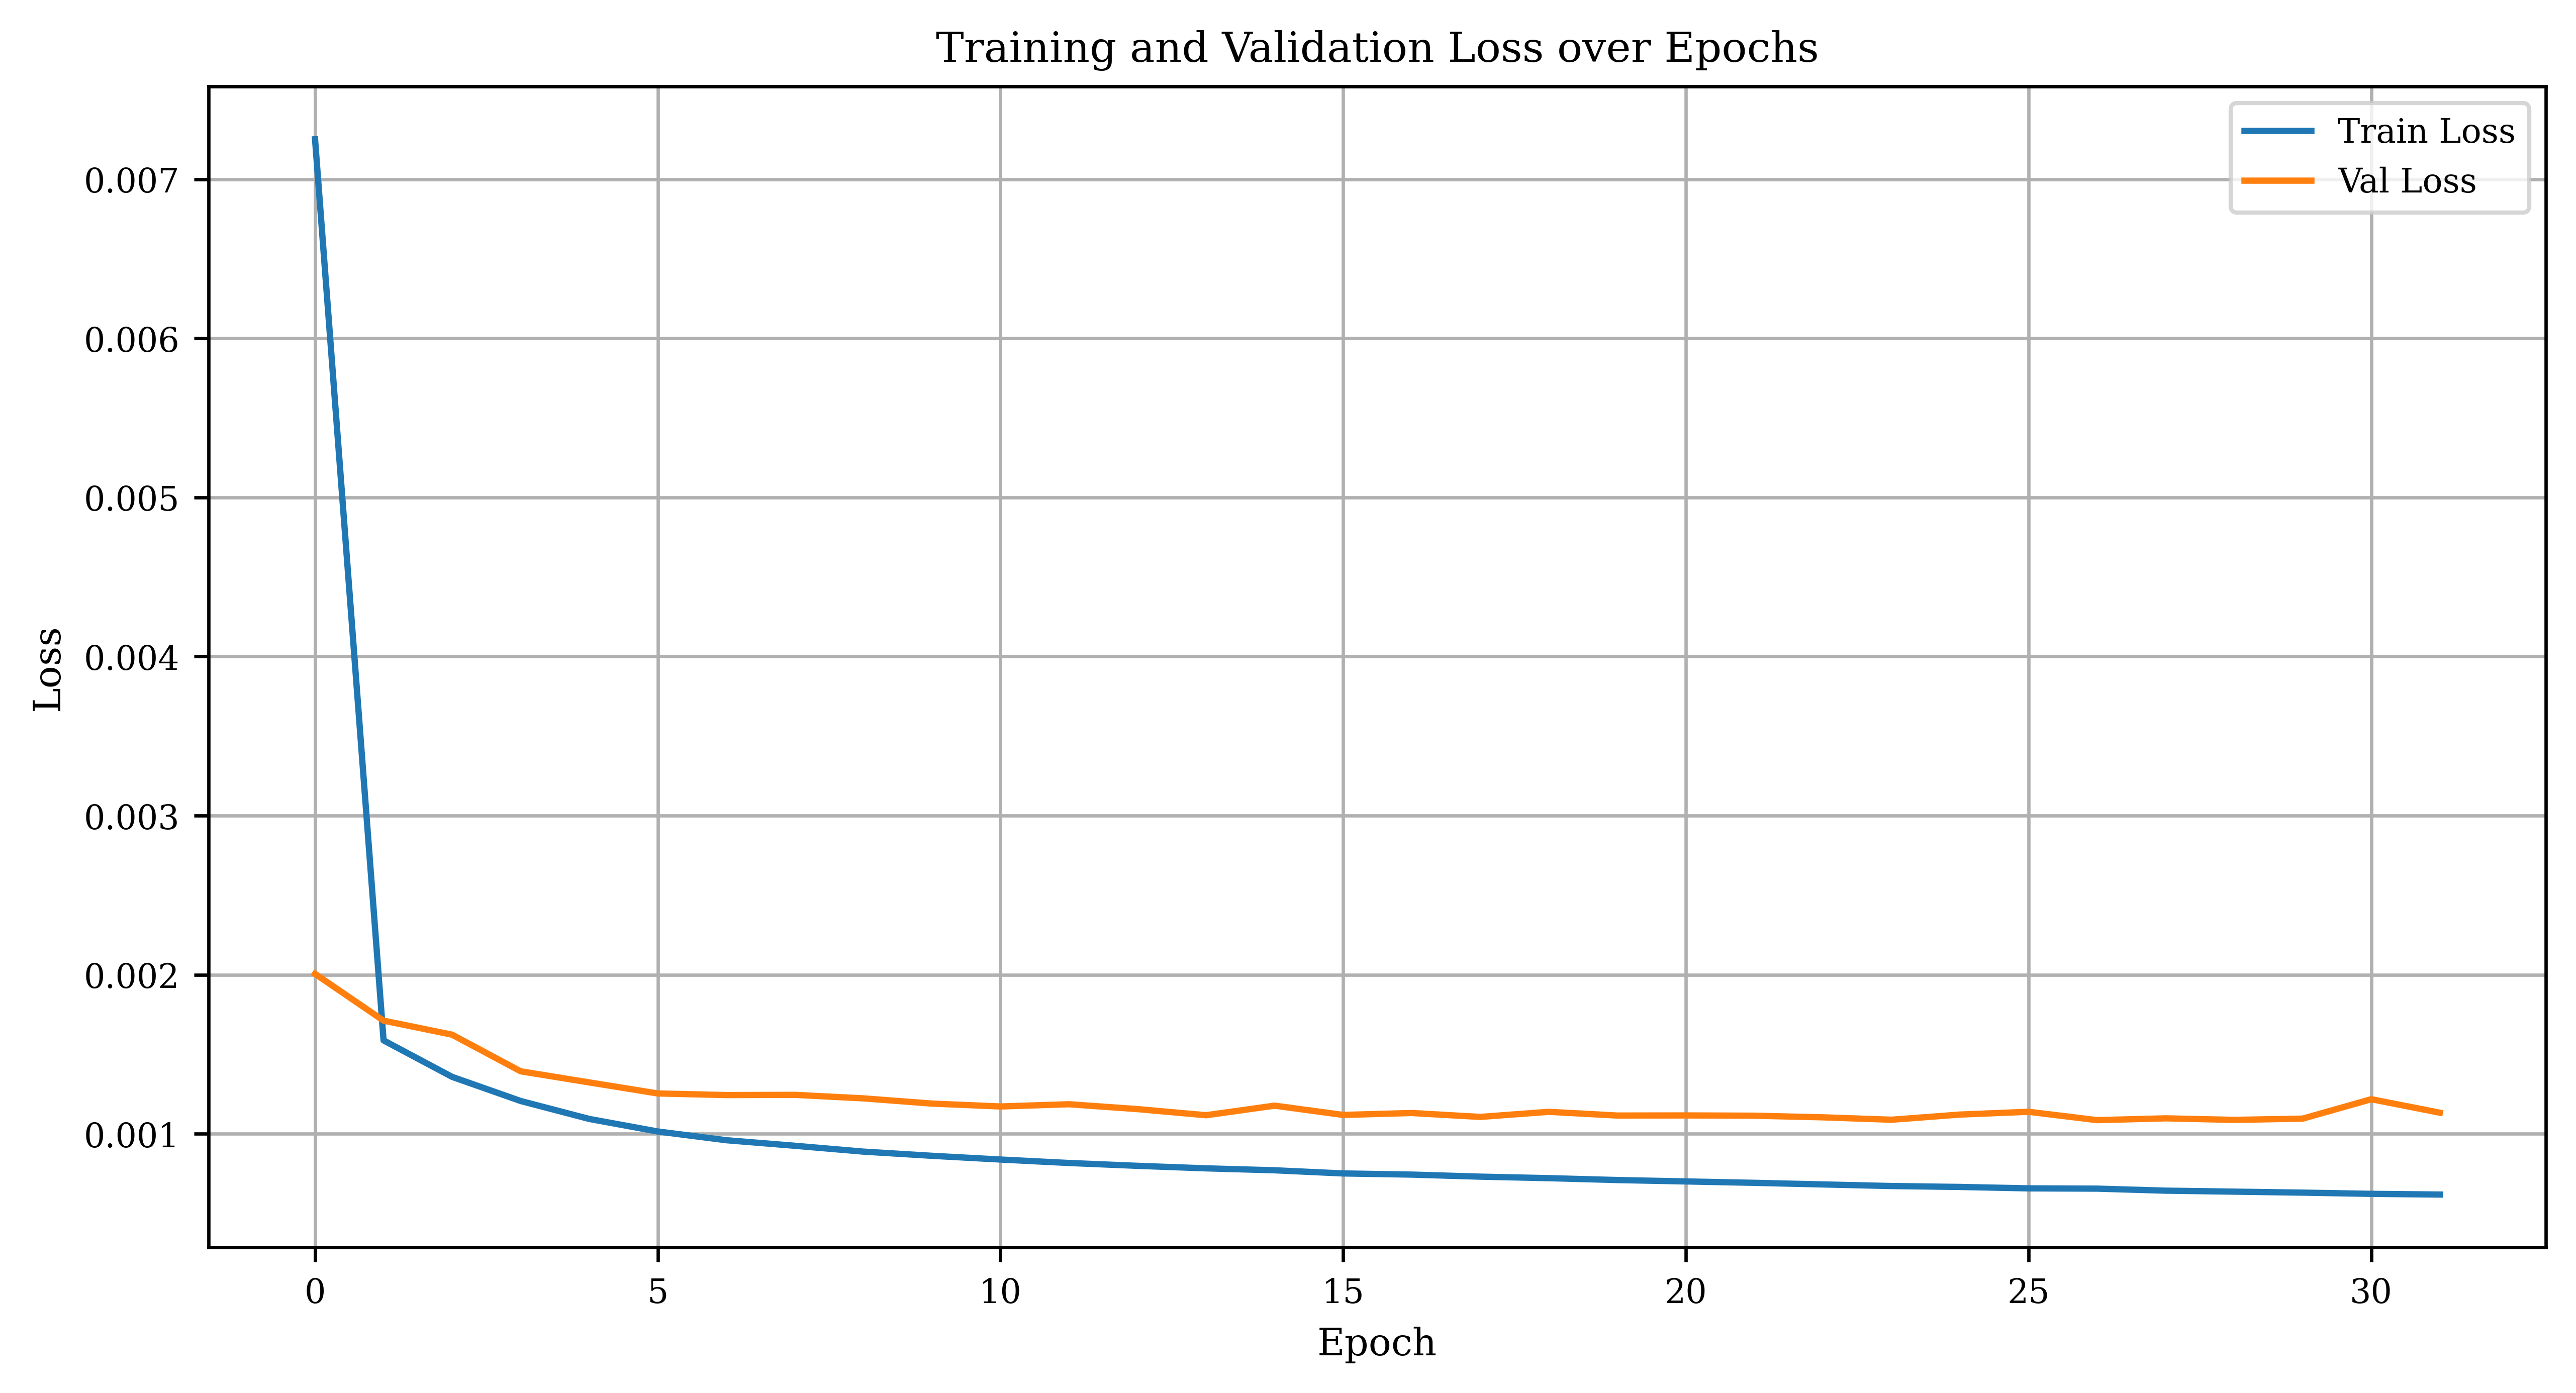

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

## Compare Trained Model to Baseline Model (ARIMA)

In [ ]:
df_scaled

,Load_Calgary,Temperature_C,Wind_Speed_mps,Is_Weekend,Is_Holiday,Day_of_Week_Num
Datetime,,,,,,
2011-01-01 00:00:00,0.264901,0.361997,0.140541,1.0,1.0,0.833333
2011-01-01 01:00:00,0.224715,0.368932,0.140541,1.0,1.0,0.833333
2011-01-01 02:00:00,0.192730,0.348128,0.167568,1.0,1.0,0.833333
2011-01-01 03:00:00,0.174687,0.320388,0.108108,1.0,1.0,0.833333
2011-01-01 04:00:00,0.168126,0.292649,0.108108,1.0,1.0,0.833333
...,...,...,...,...,...,...
2024-12-31 19:00:00,0.529682,0.355062,0.194595,0.0,0.0,0.166667
2024-12-31 20:00:00,0.480706,0.352288,0.075676,0.0,0.0,0.166667
2024-12-31 21:00:00,0.437267,0.353675,0.113514,0.0,0.0,0.166667


Determining y-axis limits...
Processing 2024-01-10...
Processing 2024-01-12...
Processing 2024-10-12...
Processing 2024-10-14...
Processing 2024-10-19...
Processing 2024-10-21...
Processing 2024-05-07...
Saved IEEE-formatted plots


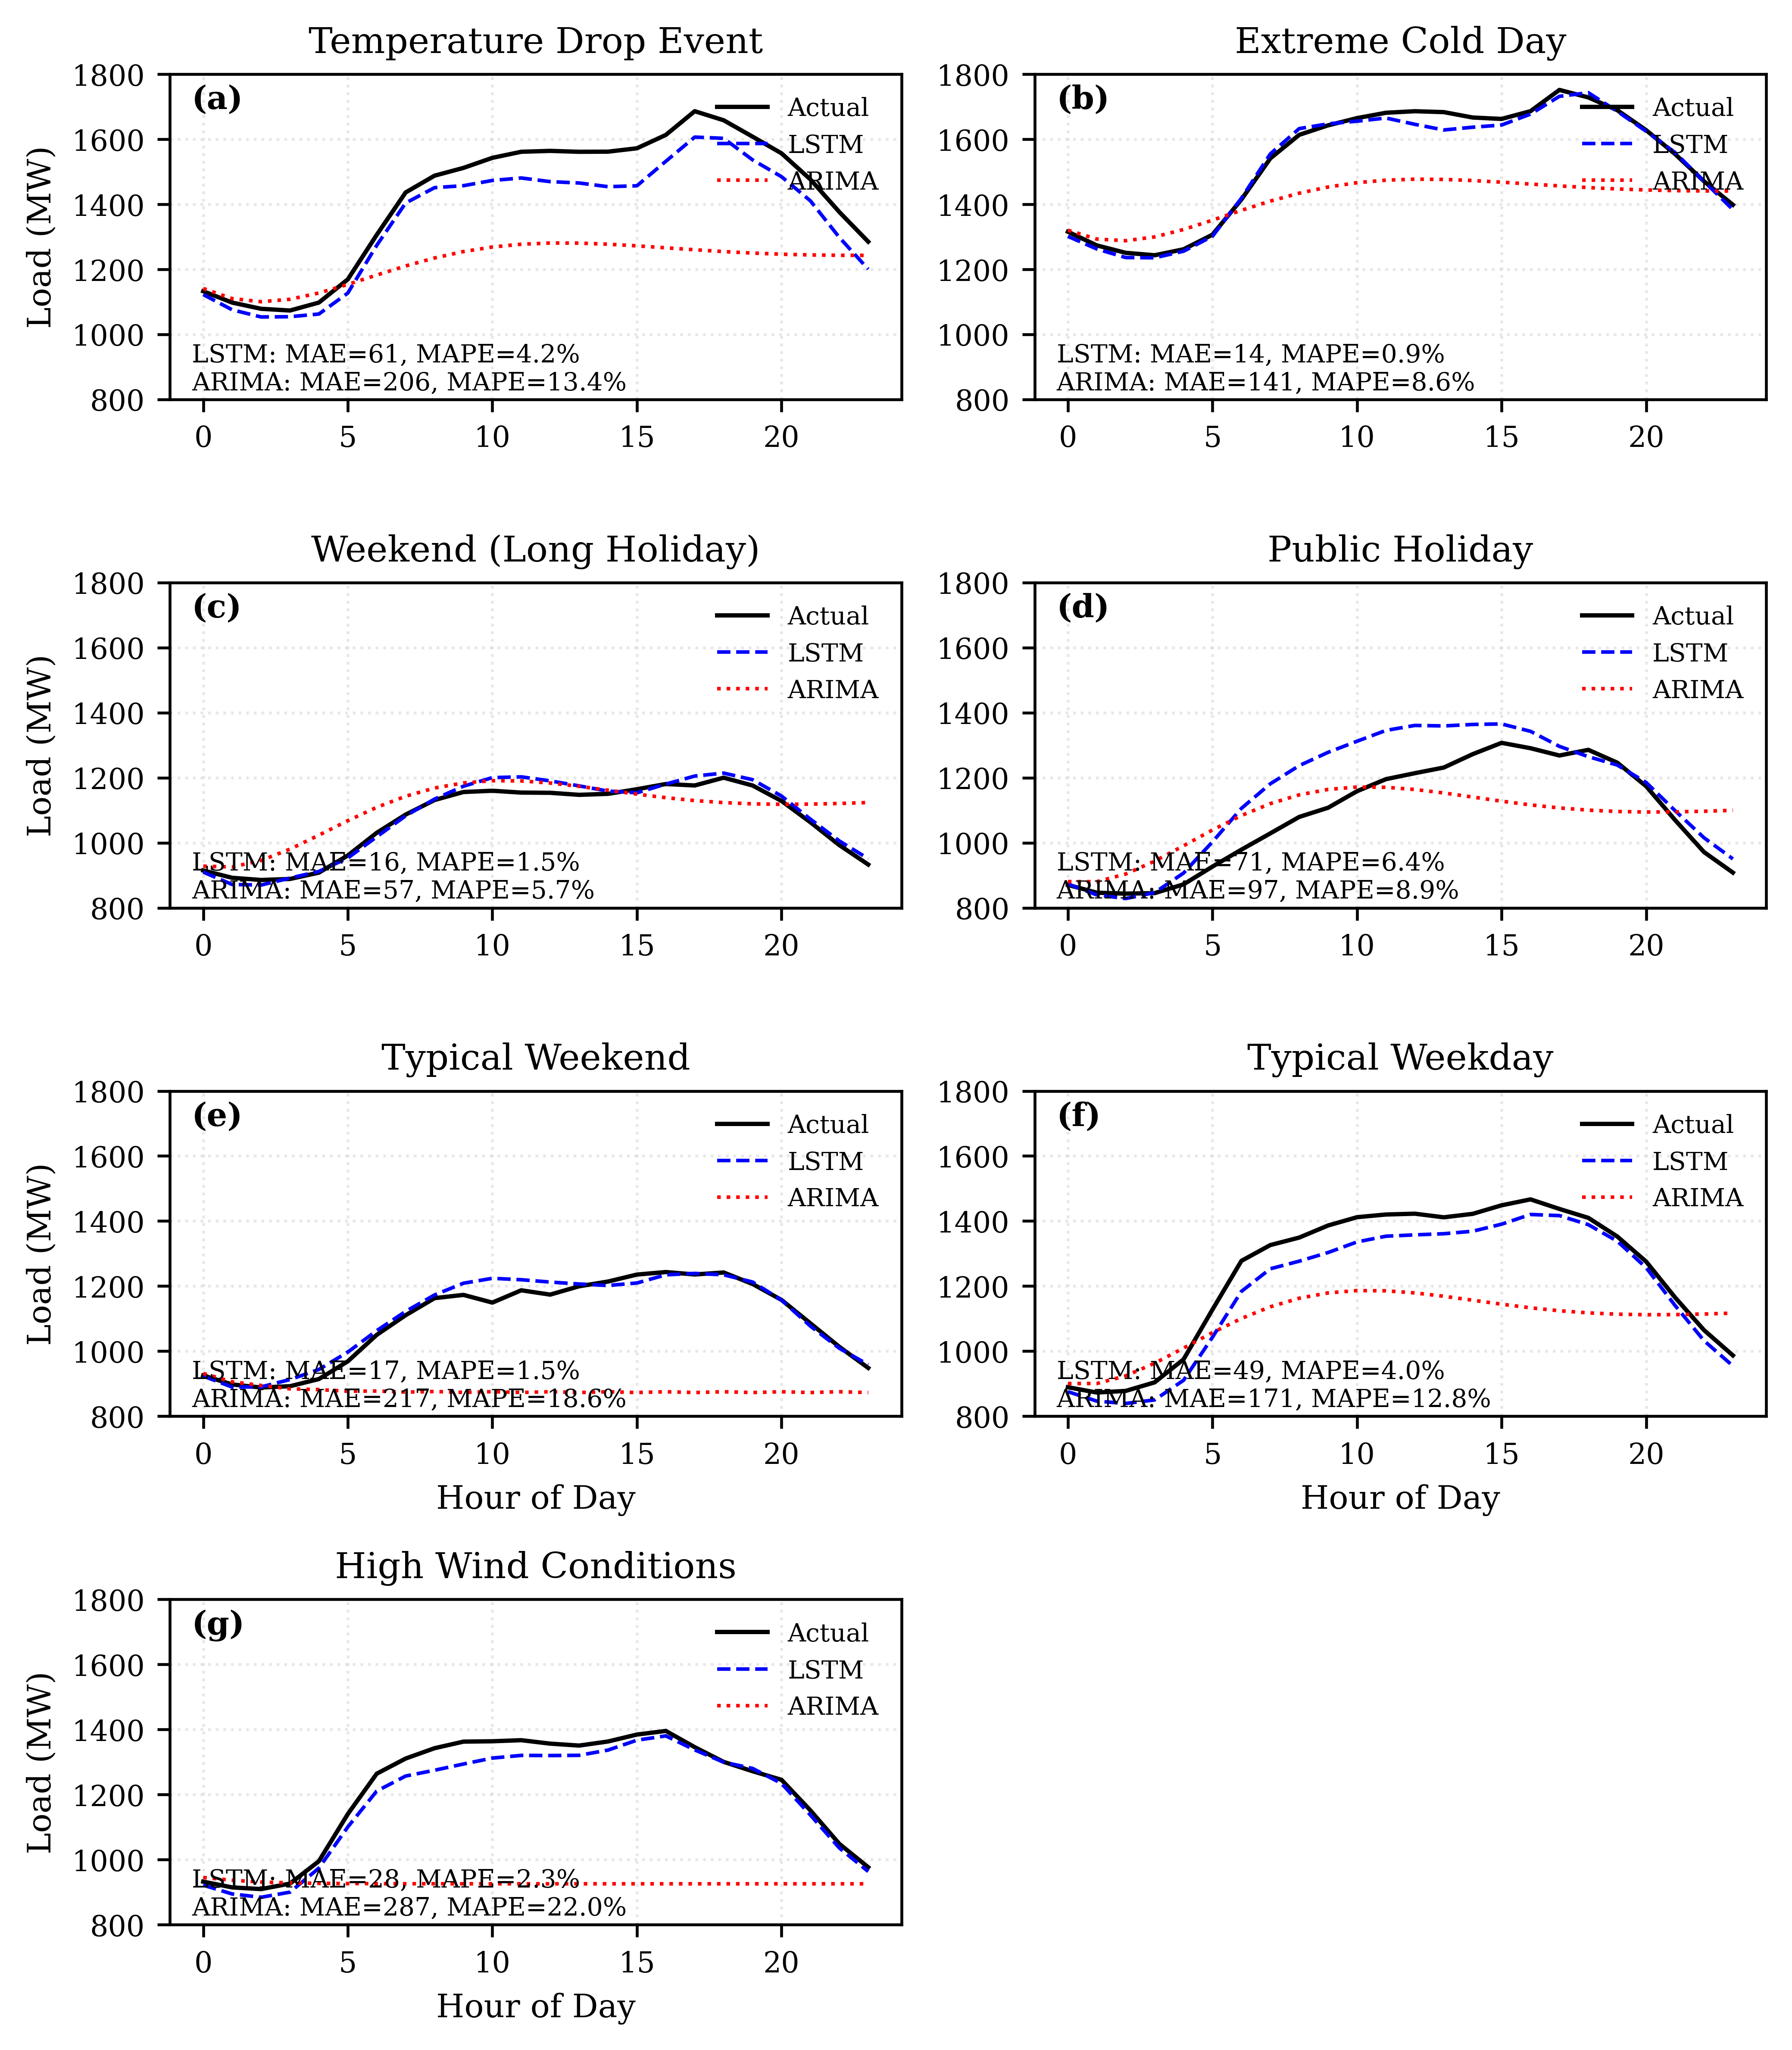

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib as mpl


def forecast_day_lstm(target_date):
    forecast_start = pd.Timestamp(target_date)
    input_start = forecast_start - timedelta(hours=24)
    input_end = forecast_start - timedelta(hours=1)
    target_end = forecast_start + timedelta(hours=23)
    X_input = df_scaled.loc[input_start:input_end, features].values
    X_tensor = torch.tensor(X_input, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        y_pred_scaled = model(X_tensor).cpu().numpy().flatten()
    y_pred = scaler.inverse_transform(np.c_[y_pred_scaled, np.zeros((24, len(features) - 1))])[:, 0]
    y_true = df.loc[forecast_start:target_end, "Load_Calgary"]
    return y_pred, y_true.values

def forecast_day_arima(target_date):
    forecast_start = pd.Timestamp(target_date)
    history_start = forecast_start - timedelta(hours=168)
    history_end = forecast_start - timedelta(hours=1)
    target_end = forecast_start + timedelta(hours=23)

    # get 7 days of history before forecast start
    history = df.loc[history_start:history_end, "Load_Calgary"]

    model = ARIMA(history, order=(2, 1, 2))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=24)

    y_true = df.loc[forecast_start:target_end, "Load_Calgary"]

    return forecast.values, y_true.values

# Set up matplotlib for IEEE paper format
mpl.rcParams.update({
    'font.family': 'serif',
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.figsize': (7, 9),
    'figure.dpi': 600,
})

start_dates = [
    "2024-01-10",  # major temp drop
    "2024-01-12",  # coldest day
    "2024-10-12",  # long weekend Saturday
    "2024-10-14",  # holiday Monday
    "2024-10-19",  # normal Saturday
    "2024-10-21",  # normal Monday
    "2024-05-07"    # max wind speed
]

# First pass: collect values for consistent y-axis scaling
print("Determining y-axis limits...")
all_values = []
for date in start_dates:
    lstm_pred, y_true = forecast_day_lstm(date)
    arima_pred, _ = forecast_day_arima(date)
    all_values.extend(y_true)
    all_values.extend(lstm_pred)
    all_values.extend(arima_pred)

y_min = 800  # Fixed to match template
y_max = 1800  # Fixed to match template

# Create figure - sized for IEEE two-column format
fig, axs = plt.subplots(4, 2, figsize=(7, 8))
axs = axs.flatten()

# Subplot labels (a-g) as shown in template
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

# Map dates to descriptions matching the template exactly
date_description = {
    "2024-01-10": "Temperature Drop Event",
    "2024-01-12": "Extreme Cold Day",
    "2024-10-12": "Weekend (Long Holiday)",
    "2024-10-14": "Public Holiday",
    "2024-10-19": "Typical Weekend",
    "2024-10-21": "Typical Weekday",
    "2024-05-07": "High Wind Conditions"
}

comparison_results = []

for i, date in enumerate(start_dates):
    if i >= len(subplot_labels):
        break

    print(f"Processing {date}...")

    # Get predictions
    lstm_pred, y_true = forecast_day_lstm(date)
    arima_pred, _ = forecast_day_arima(date)

    # Save to CSV
    comparison_df = pd.DataFrame({
        "Hour": range(24),
        "Actual_Load": y_true,
        "LSTM_Prediction": lstm_pred,
        "ARIMA_Prediction": arima_pred
    })
    comparison_df.to_csv(f"forecast_comparison_{date}.csv", index=False)

    # Plot data
    ax = axs[i]

    # Plot lines exactly as shown in template: solid black, dashed blue, dotted red
    ax.plot(range(24), y_true, color="black", linewidth=1.2, label="Actual")
    ax.plot(range(24), lstm_pred, linestyle="--", color="blue", linewidth=1, label="LSTM")
    ax.plot(range(24), arima_pred, linestyle=":", color="red", linewidth=1, label="ARIMA")

    # Add subplot label in top left
    ax.text(0.03, 0.97, subplot_labels[i], transform=ax.transAxes, fontsize=9, fontweight='bold',
            verticalalignment='top')

    # Set y-axis limits (consistent across all subplots)
    ax.set_ylim(y_min, y_max)

    # Add title centered
    title = date_description.get(date, '')
    ax.set_title(title)

    # Calculate metrics
    lstm_mae = mean_absolute_error(y_true, lstm_pred)
    arima_mae = mean_absolute_error(y_true, arima_pred)
    lstm_mape = mean_absolute_percentage_error(y_true, lstm_pred) * 100
    arima_mape = mean_absolute_percentage_error(y_true, arima_pred) * 100

    # Format metrics text exactly as shown in template
    metrics_text = f"LSTM: MAE={lstm_mae:.0f}, MAPE={lstm_mape:.1f}%\nARIMA: MAE={arima_mae:.0f}, MAPE={arima_mape:.1f}%"
    ax.text(0.03, 0.03, metrics_text, transform=ax.transAxes, fontsize=7)

    # Add legend in top right as shown in template
    ax.legend(loc='upper right', framealpha=0.0, fontsize=7)

    # Add light gray dotted grid lines
    ax.grid(True, linestyle=':', alpha=0.5, color='lightgray')

    # Only show y-axis label on left column
    if i % 2 == 0:
        ax.set_ylabel("Load (MW)")

    # Only show x-axis label on bottom row and the last subplot
    if i >= 4 or i == len(start_dates)-1:
        ax.set_xlabel("Hour of Day")

    # Collect metrics
    comparison_results.append({
        "Date": date,
        "LSTM_MAE": lstm_mae,
        "ARIMA_MAE": arima_mae,
        "LSTM_RMSE": math.sqrt(mean_squared_error(y_true, lstm_pred)),
        "ARIMA_RMSE": math.sqrt(mean_squared_error(y_true, arima_pred)),
        "LSTM_MAPE": lstm_mape,
        "ARIMA_MAPE": arima_mape
    })

# Hide the unused subplot if necessary
if len(start_dates) < 8:
    for j in range(len(start_dates), 8):
        axs[j].set_visible(False)

# Adjust spacing
plt.tight_layout()

# Save in IEEE required format
plt.savefig("forecast_comparison_ieee.png", dpi=600, bbox_inches='tight')
plt.savefig("forecast_comparison_ieee.pdf", format='pdf', bbox_inches='tight')
print("Saved IEEE-formatted plots")

# Create and save a summary metrics table
metrics_df = pd.DataFrame(comparison_results)
metrics_df.to_csv("forecast_comparison_metrics.csv", index=False)

In [ ]:
pd.DataFrame(comparison_results).to_csv("lstm_vs_arima_comparison.csv", index=False)
print("\n✅ Comparison files and plots saved for each day.")


✅ Comparison files and plots saved for each day.


## Evaluate LSTM on full test set

In [ ]:
forecast_results = []
full_timestamps = df_scaled.index
valid_test_indices = list(range(train_size + val_size, total))

for idx in tqdm(valid_test_indices):
    forecast_start = full_timestamps[idx + input_len]
    forecast_date = forecast_start.strftime("%Y-%m-%d")
    try:
        X_pred = df_scaled.loc[forecast_start - pd.Timedelta(hours=24):forecast_start - pd.Timedelta(hours=1), features].values
        X_pred_tensor = torch.tensor(X_pred, dtype=torch.float32).unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            y_pred_scaled = model(X_pred_tensor).cpu().numpy().flatten()
        y_pred = scaler.inverse_transform(np.c_[y_pred_scaled, np.zeros((24, len(features)-1))])[:, 0]
        actual_day_data = df.loc[forecast_start:forecast_start + pd.Timedelta(hours=23), "Load_Calgary"]
        if len(actual_day_data) < 24:
            continue
        y_true = actual_day_data.values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        r2 = r2_score(y_true, y_pred)
        forecast_results.append({
            "date": forecast_date,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape,
            "R2": r2
        })
    except Exception as e:
        print(f"⚠️ Skipped {forecast_date} due to error: {e}")

100%|██████████| 18404/18404 [01:08<00:00, 267.04it/s]


In [ ]:
results_df = pd.DataFrame(forecast_results)
results_df.to_csv("daily_forecast_metrics.csv", index=False)

## Evaluate ARIMA on full test set

In [ ]:
from joblib import Parallel, delayed
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math
from tqdm import tqdm

# Extract the forecasting task into a function
def process_single_forecast(idx, df, full_timestamps, input_len):
    forecast_start = full_timestamps[idx + input_len]
    forecast_date = forecast_start.strftime("%Y-%m-%d")
    try:
        history = df.loc[forecast_start - pd.Timedelta(hours=24):forecast_start - pd.Timedelta(hours=1), "Load_Calgary"]
        arima_model = ARIMA(history, order=(2, 1, 2))
        arima_model_fit = arima_model.fit()
        forecast = arima_model_fit.forecast(steps=24)
        actual_day_data = df.loc[forecast_start:forecast_start + pd.Timedelta(hours=23), "Load_Calgary"]
        if len(actual_day_data) < 24:
            return None
        y_true = actual_day_data.values
        y_pred = forecast.values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        return {
            "date": forecast_date,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape
        }
    except Exception as e:
        print(f"⚠️ ARIMA skipped {forecast_date} due to error: {e}")
        return None

# Pre-compile a model once to avoid overhead on first run
import numpy as np
dummy_data = pd.Series(np.random.randn(168))
dummy_model = ARIMA(dummy_data, order=(2, 1, 2))
dummy_model.fit()

# Method 1: Simple approach using tqdm with Parallel
print(f"Processing {len(valid_test_indices)} forecasts in parallel...")
arima_forecast_results = Parallel(n_jobs=-1)(
    delayed(process_single_forecast)(idx, df, full_timestamps, input_len)
    for idx in tqdm(valid_test_indices, desc="ARIMA Forecasting")
)

# Filter out None values (skipped forecasts)
arima_forecast_results = [r for r in arima_forecast_results if r is not None]
print(f"Successfully processed {len(arima_forecast_results)} forecasts")

Processing 18404 forecasts in parallel...


ARIMA Forecasting: 100%|██████████| 18404/18404 [04:24<00:00, 69.49it/s]


Successfully processed 18397 forecasts


In [ ]:
results_df

,date,MAE,RMSE,MAPE,R2
0,2022-11-25,25.677341,27.271661,2.259456,0.974100
1,2022-11-25,26.017349,27.765658,2.320580,0.973081
2,2022-11-25,24.324997,27.660529,2.199022,0.973839
3,2022-11-25,28.015857,33.815725,2.574668,0.962373
4,2022-11-25,29.622232,35.809822,2.752589,0.958288
...,...,...,...,...,...
18399,2024-12-30,11.311997,14.953305,0.857123,0.992161
18400,2024-12-30,11.998749,13.837171,0.926096,0.993169
18401,2024-12-30,16.181236,18.482095,1.260140,0.987645
18402,2024-12-30,19.362780,23.191571,1.514624,0.980474


In [ ]:
if not results_df.empty and len(arima_forecast_results) > 0:
    # LSTM averages
    avg_mae_lstm = results_df["MAE"].mean()
    avg_rmse_lstm = results_df["RMSE"].mean()
    avg_mape_lstm = results_df["MAPE"].mean()
    avg_r2_lstm = results_df["R2"].mean()

    # ARIMA averages
    arima_df = pd.DataFrame(arima_forecast_results)
    avg_mae_arima = arima_df["MAE"].mean()
    avg_rmse_arima = arima_df["RMSE"].mean()
    avg_mape_arima = arima_df["MAPE"].mean()

    with open("model_performance.txt", "w") as f:
        f.write("📊 Average Performance on Full Test Set\n\n")
        f.write("🔹 LSTM:\n")
        f.write(f"   MAE: {avg_mae_lstm:.2f}\n")
        f.write(f"   RMSE: {avg_rmse_lstm:.2f}\n")
        f.write(f"   MAPE: {avg_mape_lstm:.2f}%\n")
        f.write(f"   R² Score: {avg_r2_lstm:.4f}\n\n")

        f.write("🔹 ARIMA:\n")
        f.write(f"   MAE: {avg_mae_arima:.2f}\n")
        f.write(f"   RMSE: {avg_rmse_arima:.2f}\n")
        f.write(f"   MAPE: {avg_mape_arima:.2f}%\n")

In [ ]:
output_files = [
    "daily_forecast_metrics.csv",
    "model_performance.txt",
    "loss_curve.png",
    "lstm_vs_arima_comparison.csv"
] + [f"forecast_comparison_{date}.csv" for date in start_dates] \
  + [f"forecast_comparison_{date}.png" for date in start_dates]

with zipfile.ZipFile("forecast_results.zip", "w") as zipf:
    for file in output_files:
        if os.path.exists(file):
            zipf.write(file)
print("📦 All result files compressed into forecast_results.zip")

📦 All result files compressed into forecast_results.zip


In [ ]:
# Calculate weekend vs weekday metrics for both models
lstm_by_day = pd.DataFrame(forecast_results).assign(
    date=lambda x: pd.to_datetime(x['date']),
    is_weekend=lambda x: x['date'].apply(lambda d: df.loc[d.floor('D')]['Is_Weekend'])
).groupby('is_weekend').agg({'MAE': 'mean', 'MAPE': 'mean'})

arima_by_day = pd.DataFrame(arima_forecast_results).assign(
    date=lambda x: pd.to_datetime(x['date']),
    is_weekend=lambda x: x['date'].apply(lambda d: df.loc[d.floor('D')]['Is_Weekend'])
).groupby('is_weekend').agg({'MAE': 'mean', 'MAPE': 'mean'})

# Ensure both weekday and weekend data exist in both dataframes
weekend_weekday_comparison = pd.DataFrame(index=[False, True])
weekend_weekday_comparison['LSTM_MAE'] = lstm_by_day['MAE']
weekend_weekday_comparison['LSTM_MAPE'] = lstm_by_day['MAPE']
weekend_weekday_comparison['ARIMA_MAE'] = arima_by_day['MAE']
weekend_weekday_comparison['ARIMA_MAPE'] = arima_by_day['MAPE']

# Reset index and rename for clarity
weekend_weekday_comparison = weekend_weekday_comparison.reset_index().rename(
    columns={'index': 'Is_Weekend'})
weekend_weekday_comparison['Day_Type'] = weekend_weekday_comparison['Is_Weekend'].map(
    {False: 'Weekday', True: 'Weekend'})

# Final format with selected columns
weekend_weekday_comparison = weekend_weekday_comparison[
    ['Day_Type', 'LSTM_MAE', 'LSTM_MAPE', 'ARIMA_MAE', 'ARIMA_MAPE']]

# Save to CSV
weekend_weekday_comparison.to_csv('weekend_weekday_comparison.csv', index=False)
print("Weekend vs Weekday comparison saved to weekend_weekday_comparison.csv")

Weekend vs Weekday comparison saved to weekend_weekday_comparison.csv
